# Demonstrating new Designer API

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [204]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Random molecule from Enamine REAL.

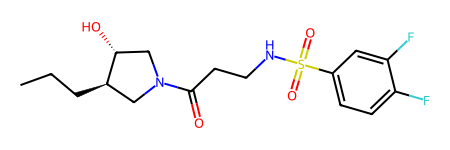

CPU times: user 211 ms, sys: 216 µs, total: 211 ms
Wall time: 21.4 ms


'13_Carboxylate_and_Amine'

In [325]:
%%time
designer.reset_cache()
res = designer.design(1)[0]
display(res)
res.reaction.name

Multi-step reaction.

In [294]:
# self = designer
# res = designer.design(1)[0]
# reaction_tree = res.dump()
# reaction_tree['reactants'] = [reaction_tree['reactants'][0], {'method': 'random'}]
# analogs = self.generate_analogs(reaction_tree, method='grow')
# for analog in analogs:
#     if 

In [409]:
%%time
designer.reset_cache()
molecule = designer.design(molecule=res, size=1, method='grow')
# print(molecule.reaction.name)
len(molecule)

CPU times: user 445 ms, sys: 0 ns, total: 445 ms
Wall time: 44.4 ms


1

Replace reactants in fragment.

In [28]:
%%time
molecule = designer.design(molecule, 1)[0]
molecule

KeyboardInterrupt: 